# Insight data challenge #1:  biopsied breast cells

Stephen Klosterman

Here I clean and explore the data, and develop a modeling approach that could be used to predict future data, with a degree of accuracy that can be tuned by the end user.

In [191]:
#Import packages
import pandas as pd
import io
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn

## Data cleaning

In [82]:
#Load data
# https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url
url="https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')), header=None)

From the problem statement:

The dataset consists of 699 cells for which you have the following features:
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

In [83]:
#First I rename columns
df.columns = ['id', 'Clump Thickness', 'Uniformity of Size',
              'Uniformity of Shape', 'Marginal Adhesion',
              'Single Epithelial Size', 'Bare Nuclei',
              'Bland Chromatin', 'Normal Nucleoli',
              'Mitoses', 'Class']

In [84]:
df.head()

,id,Clump Thickness,Uniformity of Size,Uniformity of Shape,Marginal Adhesion,Single Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Check basic data cleanliness.  Are all the ids unique?

In [85]:
np.shape(np.unique((df['id'])))

(645,)

In [86]:
df.shape

(699, 11)

In [87]:
#It appears not.  How many are duplicated, and do the duplicates have the same data?
id_count_dict = {}
for this_id in df['id'].values:
    if this_id not in id_count_dict:
        id_count_dict[this_id] = 1
    else:
        id_count_dict[this_id] += 1

(array([ 599.,    0.,   43.,    0.,    1.,    0.,    0.,    0.,    1.,    1.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

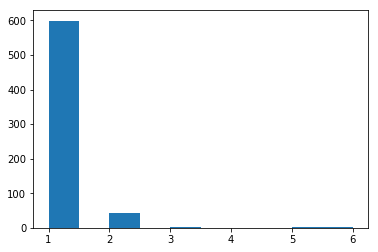

In [88]:
plt.hist(id_count_dict.values())

So there are several duplicates, and some with even more multiples.  Do replicates have the same data?

In [98]:
#Which id's have more than one row
id_counts = np.asarray(id_count_dict.values())
rep_mask = id_counts > 1

cell_ids = np.asarray(id_count_dict.keys())
rep_cell_ids = cell_ids[rep_mask]

#For these ids, is the data the same?
for rep_id in rep_cell_ids:
    this_id_data = df[df['id'].isin([rep_id])].values
    
    #Are all the rows of this array the same?
    #This will be true if so
    same_count = 0
    diff_count = 1
    test = (this_id_data == this_id_data[0]).all()
    if not test:
        diff_count +=1
        print('Different: ' + str(rep_id))
    else:
        same_count +=1
        print('Same: ' + str(rep_id))

Different: 1212422
Different: 1116192
Different: 385103
Different: 1276091
Different: 1171710
Different: 1339781
Same: 1218860
Same: 1100524
Different: 733639
Different: 897471
Different: 1174057
Different: 1114570
Different: 1182404
Different: 695091
Different: 1299596
Different: 1033078
Same: 320675
Same: 1321942
Different: 1070935
Different: 1277792
Different: 1354840
Different: 1061990
Different: 1158247
Different: 1293439
Different: 1320077
Different: 1115293
Different: 1143978
Different: 1017023
Different: 654546
Different: 1198641
Different: 493452
Different: 1168736
Different: 734111
Different: 1299924
Different: 1240603
Different: 560680
Different: 822829
Different: 769612
Same: 704097
Different: 1105524
Different: 798429
Different: 1238777
Different: 411453
Different: 1173347
Same: 1116116
Same: 466906


It looks like a few rows are exact replicates, but most are not.  I will assume that duplicate rows are repeated measurements of the same cell, and average them.  Just to get a little look, what do the data for the cell that is repeated 5 times look like?

In [99]:
df[df['id'].isin(['1276091'])]

,id,Clump Thickness,Uniformity of Size,Uniformity of Shape,Marginal Adhesion,Single Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
241,1276091,3,1,1,3,1,1,3,1,1,2
429,1276091,2,1,1,1,2,1,2,1,1,2
430,1276091,1,3,1,1,2,1,2,2,1,2
431,1276091,5,1,1,3,4,1,3,2,1,2
462,1276091,6,1,1,3,2,1,1,1,1,2


The data are slightly different; averaging seems to make sense.  If, after averaging, there are different classes than only 2 or 4 in the data set, this implies that some cells were classified differently upon repeated measurements.  I will round the classes to 2 or 4 in this case, effectively taking a majority vote of the repeated measurement.  For the cases of two measurements, this is more problematic because there would be no majority.  For these, it seems like there would be no certainty in the class of the cell and it should be discarded from the data set.

In [146]:
grouped_df = df.groupby(['id']).mean()

In [147]:
grouped_df.shape

(645, 9)

In [148]:
#This has the same number of rows as there are unique cell ids.  Good.  What are the classes?
grouped_df['Class'].unique()

array([ 2.        ,  4.        ,  3.        ,  2.66666667])

Looks like there were some even splits (i.e. class = 3), which I'll drop.  I'll set 2.6 = 2 since the majority vote was 2 there.

In [149]:
grouped_df = grouped_df[grouped_df['Class']!=3]

In [150]:
grouped_df.shape

(642, 9)

In [151]:
grouped_df['Class'][grouped_df['Class']==(2.+2./3.)] = 2.

In [152]:
grouped_df['Class'].unique()

array([ 2.,  4.])

Now all the observations are independent and I am only using the ones that have a clear class based on the data.

This is a classification problem and I will encode 4 as 1 and 2 as 0, defining "success" as a malignant tumor even though that's the opposite of what anyone wants.

In [153]:
grouped_df['Class'][grouped_df['Class']==4] = 1
grouped_df['Class'][grouped_df['Class']==2] = 0

In [154]:
grouped_df['Class'].unique()

array([ 0.,  1.])

## Data exploration

In [155]:
grouped_df.head()

,Clump Thickness,Uniformity of Size,Uniformity of Shape,Marginal Adhesion,Single Epithelial Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
id,,,,,,,,,
61634,5.0,4.0,3.0,1.0,2.0,2.0,3.0,1.0,0.0
63375,9.0,1.0,2.0,6.0,4.0,7.0,7.0,2.0,1.0
76389,10.0,4.0,7.0,2.0,2.0,6.0,1.0,1.0,1.0
95719,6.0,10.0,10.0,10.0,8.0,7.0,10.0,7.0,1.0
128059,1.0,1.0,1.0,1.0,2.0,5.0,1.0,1.0,0.0


In [157]:
X = grouped_df.drop('Class', 1)

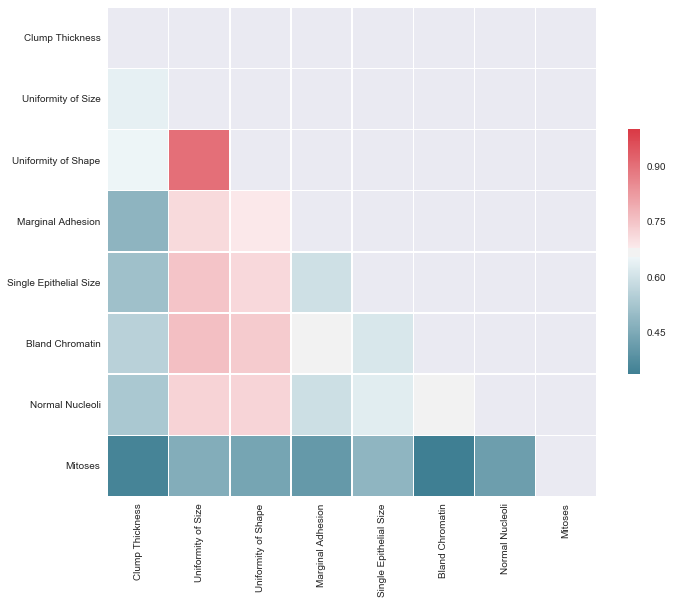

In [161]:
#Make covariance heatmap of predictors, see if any have large correlation
# http://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Uniformity of size and uniformity of shape are highly correlated; it may be that only one of these actually needs included in the model.  Keep this in mind for later.

Now I check on whether any features have clear class separability.

In [ ]:
#Convert features to array
X = X.values

In [163]:
#Get masks for benign and malignant
benign_mask = grouped_df['Class'] == 0
mal_mask = grouped_df['Class'] == 1

I also note here that the classes are relatively evenly balanced:

In [190]:
sum(benign_mask)/float(len(benign_mask))

0.64018691588785048

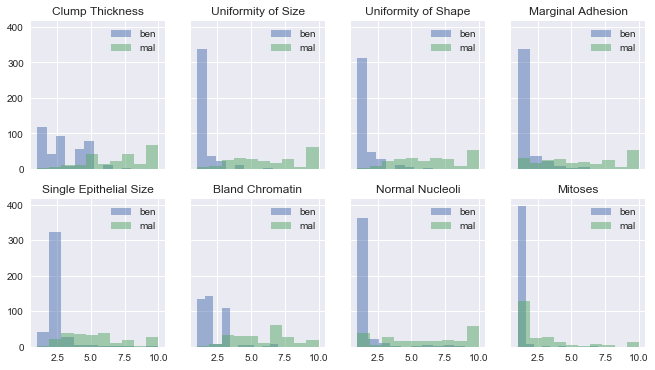

In [184]:
#Plot each feature separately by classification, see if any have clear class separability

#There are 8 predictors
fig, axes = plt.subplots(2, 4, sharex='all', sharey='all', figsize=(11, 6))

axes = axes.ravel()

for i in range(X.shape[1]):
    axes[i].hist(X[benign_mask,i], alpha=0.5, label='ben')
    axes[i].hist(X[mal_mask,i], alpha=0.5, label='mal')
    axes[i].legend(loc='upper right')
    axes[i].set_title(grouped_df.columns.values[i])


It looks like for most features, benign cells are clumped along the lower end of the spectrum, while malignant are more evenly spread through.  Together with the fact that not all features are highly correlated, this suggests a modeling approach may be able to discriminate between benign and malignant cells.

## Modeling

I try a logistic regression, which I validate using stratified 5 fold CV, to keep classes as balanced as possible in the splits.

This model has the advantage that the user has some control over true and false positive rates, if for example succesful detection of malignant cells should be prioritized over wrongly classifying some benign cells as malignant.

In [192]:
np.shape(X)

(642, 8)

In [193]:
y = grouped_df['Class'].values
np.shape(y)

(642,)

In [201]:
n_folds = 5

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds)
skf.get_n_splits(X, y)

5

In [202]:
print(skf)  

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


Do the splits on the data, train and test a logistic regression model.
I will assume here that accuracy is the desired metric to examine.

In [231]:
#Instantiate model
from sklearn import linear_model
logistic_reg_model = linear_model.LogisticRegression(fit_intercept = True, class_weight='balanced', C=1)

In [232]:
counter = 0
scores = [None]*n_folds

for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print(counter)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est = logistic_reg_model.fit(X_train, y_train)
    scores[counter] = est.score(X_test, y_test)
    counter += 1

In [233]:
scores

[0.96923076923076923, 0.9453125, 0.9609375, 0.9609375, 0.9765625]

Cross validation accuracy scores are relatively high, definitely better than a null model that would select all true or all false.

At this point, my three hours for this challenge are almost up.  If I had unlimited time, I would explore other models, such as random forest, support vector machine, or boosted trees, to see if higher accuracy could be obtained.  

I would also do a formal examination and plot of a range of values for the regularization parameter of the logistic regression.  I explored a few values by hand and accuracy was highest for C = 1 or 10, at least for these folds.

I might also try removing one of those highly correlated predictors, to see if that changes things.

However in the time remaining, it seems best to explore the insights that can be gained from the logistic regression model.  I consider the model to be successfully cross-validated, and explore what an ROC curve looks like, for a model that has been trained on all the data.

In [234]:
#Train model on all data
est = logistic_reg_model.fit(X, y)

In [238]:
#Get ROC curve metrics
roc = sklearn.metrics.roc_curve(y, est.predict_proba(X)[:,1])

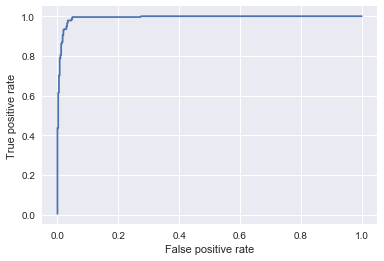

In [237]:
# Plot ROC curve
plt.plot(roc[0], roc[1], '-x')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In general this ROC curve hugs the upper left corner, which indicates area under the curve close to one and generally a good classifier.  This curve enables tuning of the classifier.

As a hypothetical situation, if I had some desired true positive rate for detecting malignant cells, for example 99%, what false positive rate would be necessary for this?

In [239]:
#Find index of element with closest value to 0.99 TPR
want_true_pos = 0.99
roc_diff = roc[1] - want_true_pos
roc_index = np.argmin(np.abs(roc_diff))
actual_true_pos = roc[1][roc_index]
false_pos_rate_for_this_true_pos = roc[0][roc_index]


In [240]:
print(actual_true_pos, false_pos_rate_for_this_true_pos)

(0.98701298701298701, 0.046228710462287104)


So we can detect about 99% of malignant cells with a 5% false positive rate.  The client should decide if this meets their needs, or should be adjusted.